<a href="https://colab.research.google.com/github/iatra/COSC2673-Assignment2-Group9/blob/main/s4005248_s3980067.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning COSC2673-Assignment2-Group9
Author : Joelle Lee Ming Yin (s3980067) & Isabella Tranquilino (s4005248)

## Approach

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ML A2 Dataset/Image_classification_data.zip'

import zipfile
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

# List first few files/folders in the extraction folder
extracted_path = '/content/data'
for root, dirs, files in os.walk(extracted_path):
    print(f"Directory: {root}")
    for file in files[:5]:  # Show up to 5 files per directory
        print(f"  - {file}")
    break  # Remove this if you want to see all subfolders


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory: /content/data
  - data_labels_extraData.csv
  - data_labels_mainData.csv


Load Libraries

In [ ]:
# --- Library Imports ---
# Standard Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 # If used for image loading/processing beyond ImageDataGenerator

# TensorFlow / Keras
from tensorflow.keras.models import Sequential, load_model # Added load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical # Added to_categorical
from tensorflow.keras import regularizers

# Scikit-learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split # Added train_test_split

# PIL (Pillow)
from PIL import Image


In [ ]:
df_main = pd.read_csv('/content/data/data_labels_mainData.csv')
df_extra = pd.read_csv('/content/data/data_labels_extraData.csv')

df_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [ ]:
df_extra.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


### Class Imbalance Identification

In [ ]:
#--------- Check class imbalance in cellTypeName -------------
class_counts_named = df_main['cellTypeName'].value_counts()
print("Class distribution (by name):")
print(class_counts_named)

# Calculate percentage of each unique cell type
data = {'cellTypeName': ['epithelial'] * 4079 + ['inflammatory'] * 2543 + ['fibroblast'] * 1888 + ['others'] * 1386}
df_temp = pd.DataFrame(data)

class_percentages_named = df_temp['cellTypeName'].value_counts(normalize=True) * 100
print("Class distribution (by percentage):")
print(class_percentages_named.round(2))

Class distribution (by name):
cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64
Class distribution (by percentage):
cellTypeName
epithelial      41.22
inflammatory    25.70
fibroblast      19.08
others          14.01
Name: proportion, dtype: float64


Based on the numbers and percentages, we can identify a class imbalance present in the CellTypeName distribution. We can see that the proportion of each cell is not equal with the epithelial cell being the most frequent.

**Implication:**


1.   The Machine Learning model that we will train might be biased towards the epithelial cell type because it appears the most frequent. The ML model might predict this class more often than the others and it might not identify cell type right.
2.   The model might also struggle to learn characteristics of the minority classes such as 'Fibroblast' due to limited image examples during the training which can lead to low classification scores.




In [ ]:
#--------- Check class imbalance in isCancerous -------------
print("Main Data - isCancerous distribution:")
print(df_main['isCancerous'].value_counts())

# Calculate percentage of isCancerous
main_data = {'isCancerous': [0] * 5817 + [1] * 4079}
df_main_temp = pd.DataFrame(main_data)

main_percentages = df_main_temp['isCancerous'].value_counts(normalize=True) * 100
print("Main Data - isCancerous distribution (by percentage):")
print(main_percentages.round(2))

#--------- Check class imbalance in isCancerous - extra Data -------------
print("Extra Data - isCancerous distribution:")
print(df_extra['isCancerous'].value_counts())

# Calculate percentage of isCancerous - extra Data
class_percentages_extra = df_extra['isCancerous'].value_counts(normalize=True) * 100
print("\nExtra Data - isCancerous distribution (by percentage):")
print(class_percentages_extra.round(2))

Main Data - isCancerous distribution:
isCancerous
0    5817
1    4079
Name: count, dtype: int64
Main Data - isCancerous distribution (by percentage):
isCancerous
0    58.78
1    41.22
Name: proportion, dtype: float64
Extra Data - isCancerous distribution:
isCancerous
0    7394
1    2990
Name: count, dtype: int64

Extra Data - isCancerous distribution (by percentage):
isCancerous
0    71.21
1    28.79
Name: proportion, dtype: float64


Not a drastic change in class imbalance for the main data but for the extra data shows a more significant class imbalance, the non-cancerous class has a larger representation than the cancerous class.

In [ ]:
#--------- Check class imbalance in cellType -------------
class_counts = df_main['cellType'].value_counts().sort_index()
print("Class distribution (by numeric label):")
print(class_counts)

# Calculate percentage of cellType
data_numeric = {'cellType': [0] * 1888 + [1] * 2543 + [2] * 4079 + [3] * 1386}
df_numeric = pd.DataFrame(data_numeric)

class_percentages_numeric = df_numeric['cellType'].value_counts(normalize=True) * 100
print("Class distribution (by percentage):")
print(class_percentages_numeric.round(2).sort_index())

Class distribution (by numeric label):
cellType
0    1888
1    2543
2    4079
3    1386
Name: count, dtype: int64
Class distribution (by percentage):
cellType
0    19.08
1    25.70
2    41.22
3    14.01
Name: proportion, dtype: float64


*There*'s a noticeable class imbalance in the cellType distribution. Class 2 is almost 3 times larger than the Class 3.

Visualisations of these class imbalance distributions per target columns can be seen in the EDA section.

### Exploratory Data Analysis (EDA)
Some cells of code in this section have been retrieved from the Week 6 Lab and have been adapted to fit this task.

In [ ]:
#--------- Initial exploration into dataframe -------------
df_main.info()
df_main.describe()

#checking for missing vals
df_main.isnull().sum() #no missing labels in any cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


,0
InstanceID,0
patientID,0
ImageName,0
cellTypeName,0
cellType,0
isCancerous,0


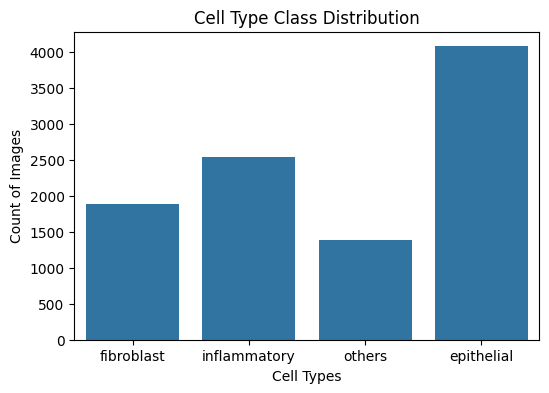

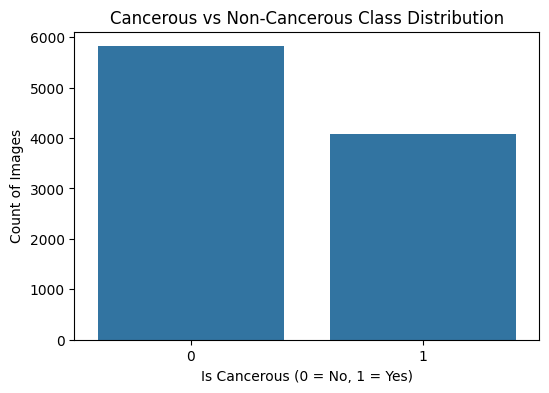

In [ ]:
#-------- Target variables class distributions ----------
df_main['cellTypeName'].value_counts()
df_main['isCancerous'].value_counts()

#plotting distributions
plt.figure(figsize=(6, 4))
sns.countplot(data=df_main, x='cellTypeName')
plt.xlabel('Cell Types')
plt.ylabel('Count of Images')
plt.title('Cell Type Class Distribution')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(data=df_main, x='isCancerous')
plt.xlabel('Is Cancerous (0 = No, 1 = Yes)')
plt.ylabel('Count of Images')
plt.title('Cancerous vs Non-Cancerous Class Distribution')
plt.show()

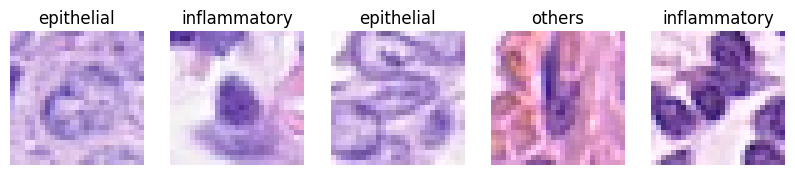

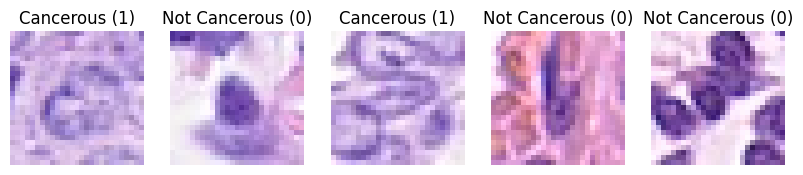

In [ ]:
# ------------- Displaying sample images --------------

image_dir = '/content/data/patch_images/'

#grabbing 5 sample images
sample_images = df_main.sample(5)

#displaying sample images
f, axarr = plt.subplots(1, 5, figsize=(10, 5))
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName']) #accessing images from patch_images folder/dir
    img = Image.open(img_path)
    axarr[i].imshow(img)
    axarr[i].axis('off')
    axarr[i].set_title(row['cellTypeName'])  #display cell type names
plt.show()

f, axarr = plt.subplots(1, 5, figsize=(10, 5))
for i, (_, row) in enumerate(sample_images.iterrows()):
    img_path = os.path.join(image_dir, row['ImageName']) #accessing images from patch_images folder/dir
    img = Image.open(img_path)
    axarr[i].imshow(img)
    axarr[i].axis('off')
    cancer_identification = "Cancerous (1)" if row['isCancerous'] == 1 else "Not Cancerous (0)" #renaming label 1 or 0 to Cancerous or Not Cancerous
    axarr[i].set_title(cancer_identification)  #display isCancerous or Not
plt.show()


The visual samples of the data above, may pose potential issues during model training. The resolution of the images may cause reduced pixel quality of important features used to identify cell type and if it is cancerous or not, this may hinder the ability for the models to learn features and thus hinder overall performance of classification.

In [ ]:
#----------- Checking image sizes --------------
image_sizes = []

#checking through each image
for img_name in df_main['ImageName']:
    img_path = os.path.join(image_dir, img_name)
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  #size of each image to list
    except:
        continue

print("Image sizes:")
for size in sorted(set(image_sizes)):
    print(size)

Image sizes:
(27, 27)


### Pre-processing of Data

In [ ]:
# Add image path to DataFrame by creating a column to benefit adding images later
df_main['ImagePath'] = df_main['ImageName'].apply(lambda x: os.path.join(image_dir, x))

# Convert labels into one-hot encoded formats
y_isCancerous = to_categorical(df_main['isCancerous'].values, num_classes=2)
# Converted cell type labels to one-hot encoded formats 0,1,2,3
y_cellType = to_categorical(df_main['cellType'].values, num_classes=4)

##### Split into training, validation and test set

The dataset was split in a 60:20:20 split of train, validation and test set respectively. 60% used for training allows for models to effectively learn patterns in the data, 20% for validation allows for the models to use this set as unseen data to monitor parameter tuning and overfitting/underfitting during training, and 20% for testing provides a final evaluation of the model's final performance on unseen data.The split strategy is performed for both "isCancerous" (y1) and "cellType" (y2) target columns.

The first split separates the data in to 80% and 20% placeholders, whilst using stratified sampling to maintain class balance in the test set as well for fair evaluation.

The second split then further separates the 80% into 60% for training, with 20% for validation and the other 20% for testing.

The **purpose of the validation set** in these models is to assess the performance during training whilst iteratively tuning the parameters, it also detected how well the model was fitting onto the data, and if it is overfitting or not.

In [ ]:
# First Split - splitting into 80% for initial training X_train, and 20% test
# y_isCancerous into y1_train, y1_val, and y1_test @Isabella
# y_cellType into y2_train, y2_val, and y2_test @Joelle
# Split is based on isCancerous column to ensure the proportion of cancerous and non-cancerous samples is roughly the same in test and train sets. (Beneficial for potential class imbalance)
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(
    df_main['ImagePath'].values, y_isCancerous, y_cellType,
    test_size=0.2, stratify=df_main['isCancerous'], random_state=42
)

# Second Split - splitting the 80% further to 60% for training and the validation set to 20%
# Stratifying the split based on isCancerous labels in the training set to convert the one-hot encoded to its original 0 or 1 label. To ensure the validation set also has a good portion of the isCancerous classes.
X_train, X_val, y1_train, y1_val, y2_train, y2_val = train_test_split(
    X_train, y1_train, y2_train,
    test_size=0.25, stratify=np.argmax(y1_train, axis=1), random_state=42
)

##### Image loader with normalization

In [ ]:
def load_images(image_paths, target_size=(27, 27)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue
        img = cv2.resize(img, target_size)
        img = img.astype('float32') / 255.0  # normalize to [0, 1]
        images.append(img)
    return np.array(images)

#### Print train, validation and test shapes

In [ ]:
# Load image arrays
x_train = load_images(X_train) # 72 % of the original data
x_val = load_images(X_val) # 8% of the original data
x_test = load_images(X_test) # 20% of the original data

# Confirm shapes
print("x_train shape:", x_train.shape)
print("y1_train shape (isCancerous):", y1_train.shape)
print("y2_train shape (cellType):", y2_train.shape)

x_train shape: (5937, 27, 27, 3)
y1_train shape (isCancerous): (5937, 2)
y2_train shape (cellType): (5937, 4)


7124 samples in the training set
27x27 height and width of each image
3 RGB colours because the colour isnt grayscaled. The shapes are consistent after normalising to prepare for the classification tasks.

The following are ready for model training:

*   isCancerous prediction - y1_train
*   cellType prediction - y2_train
*   validation models - x_val, y1_val, y2_val
*   final evaluation - x_tests, y1_test, y2_test  


**Performance Metrics Selection**

Due to the class imbalances within both columns "isCancerous" and "cellType" as seen in EDA, the accuracy metric itself when evaluating models *may provide misleading information* as it ignores how well each class is predicted. The addition of precision, recall, AUC and F1-score performance metrics ensures that the model can be judged overall and identifies how many cases in each class are correctly predicted per column.

### Task 1: Classifying Cancerous Cell or Not
**Author: Isabella**

Some cells of code in this section have been retrieved from the Week 6, 7, and 8 Lab and have been adapted to fit this task.

#### Model Building (Baseline)

In [ ]:
#---------- CNN Y1 (isCancerous) Baseline model architecture ------------
y1_cnn_baseline = Sequential()
y1_cnn_baseline.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
y1_cnn_baseline.add(Activation('relu'))
y1_cnn_baseline.add(MaxPooling2D(pool_size =(2,2)))

y1_cnn_baseline.add(Conv2D(64, (3, 3)))
y1_cnn_baseline.add(Activation('relu'))
y1_cnn_baseline.add(MaxPooling2D(pool_size =(2,2)))

y1_cnn_baseline.add(Flatten())
y1_cnn_baseline.add(Dense(64))
y1_cnn_baseline.add(Activation('relu'))
y1_cnn_baseline.add(Dense(2)) #number of classes for y1
y1_cnn_baseline.add(Activation('softmax'))

optimizer = Adam(learning_rate=0.001)
y1_cnn_baseline.compile(loss='categorical_crossentropy',
                     optimizer=optimizer,
                     metrics=['accuracy',
                              metrics.Precision(name='precision'),
                              metrics.Recall(name='recall'),
                              metrics.AUC(name='auc')]
                     )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fitting y1 onto the baseline model
history_baseline_y1 = y1_cnn_baseline.fit(x_train, y1_train,
                 epochs=100,
                 batch_size=32,
                 validation_data=(x_val, y1_val),
                  verbose=0)

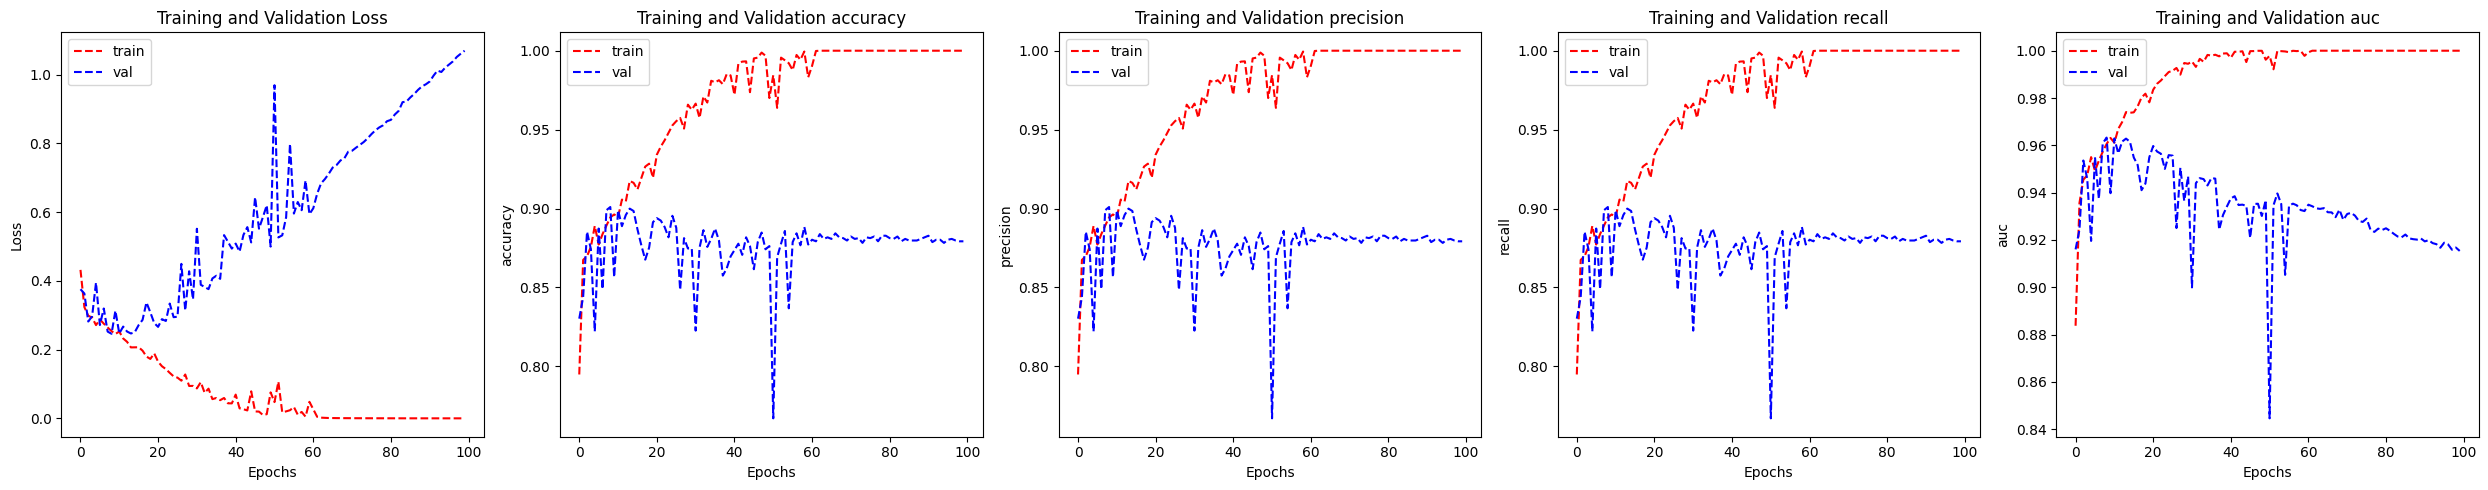

In [ ]:
# Plotting learning curve of baseline model to check for overfitting
def plot_learning_curves(history, metrics_list):
    n_metrics = len(metrics_list)
    plt.figure(figsize=(5 * (n_metrics + 1), 5))

    # Loss learning curve
    plt.subplot(1, n_metrics + 1, 1)
    plt.plot(history.history['loss'], 'r--')
    plt.plot(history.history['val_loss'], 'b--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend(['train', 'val'], loc='upper left')

    # Metrics learning curve
    for i, metric in enumerate(metrics_list, start=2):
        plt.subplot(1, n_metrics + 1, i)
        plt.plot(history.history[metric], 'r--')
        plt.plot(history.history['val_' + metric], 'b--')
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.title(f"Training and Validation {metric}")
        plt.legend(['train', 'val'], loc='upper left')

    plt.tight_layout()
    plt.show()

plot_learning_curves(history_baseline_y1, ['accuracy', 'precision', 'recall', 'auc'])

**Baseline Model Generalisation**

From the loss, accuracy, recall, and ROC-AUC learning curve above, it is clear that the **baseline model is overfitting the data**.

The large gap between the train and validation sets indicates that the model is fitting too well to the training data and  not performing well on the validation data acting as unseen data.

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:

               precision    recall  f1-score   support

Non-cancerous       0.91      0.88      0.90      1163
    Cancerous       0.84      0.87      0.86       816

     accuracy                           0.88      1979
    macro avg       0.87      0.88      0.88      1979
 weighted avg       0.88      0.88      0.88      1979



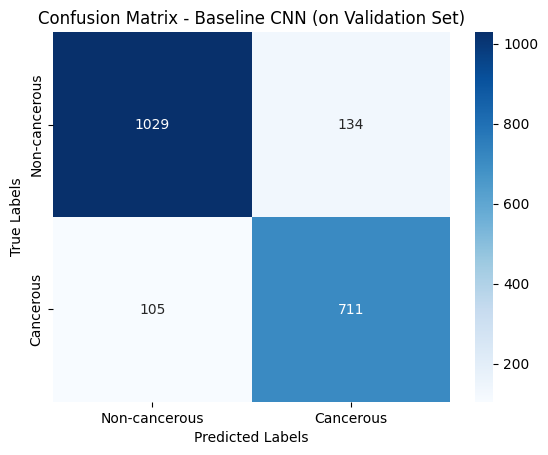

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


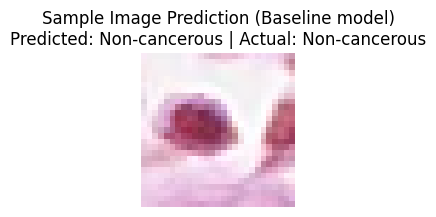

In [ ]:
#---------- Evaluating Baseline Model ----------
y1_val_probs = y1_cnn_baseline.predict(x_val) # baseline model predicting on the validation set

# Convert one-hot predictions and labels to class indices
y1_val_pred = np.argmax(y1_val_probs, axis=1)
y1_val_true = np.argmax(y1_val, axis=1)

# Classification report
class_labels = ['Non-cancerous', 'Cancerous']
print("Classification Report:\n")
print(classification_report(y1_val_true, y1_val_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y1_val_true, y1_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Baseline CNN (on Validation Set)')
plt.show()

# Sample image prediction on validation set
import random
def predict_random_image(x_data, y_data, model, class_labels):
    idx = random.randint(0, len(x_data) - 1) #random image

    img = x_data[idx] #retrieving random image
    actual_label = np.argmax(y_data[idx]) if y_data.ndim > 1 else y_data[idx] #retrieving actual label of the random image

    img_input = np.expand_dims(img, axis=0) #batch dimension

    #predicting image on baseline model
    prediction = model.predict(img_input)
    predicted_class = np.argmax(prediction)


    plt.figure(figsize=(3, 2))
    plt.imshow(img)
    plt.title(f"Sample Image Prediction (Baseline model)\nPredicted: {class_labels[predicted_class]} | Actual: {class_labels[actual_label]}")
    plt.axis('off')
    plt.show()

predict_random_image(x_val, y1_val, y1_cnn_baseline, class_labels)

**Baseline Model Evaluation**

Baseline model implemented a CNN architecture over MLP due to its ability to capture spatial patterns in images.

The baseline model's performance in predicting isCancerous displays a high f1-score of 0.88 and other metrics. Whilst this baseline model is performing relatively well, the above learning curves presented clear overfitting of the data, to which concludes that this model's performance is not the best representation for generalising to unseen data/new images. Making this model unfit.

#### Model Training (Parameter Tuning)

Class distribution: [3490. 3490.]


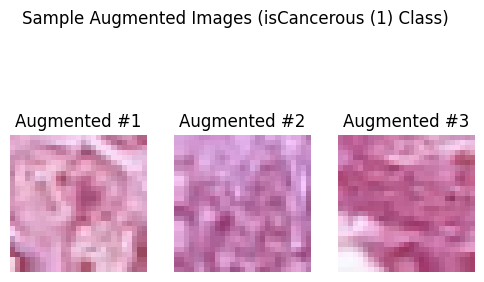

In [ ]:
#---------- Handling Class Imbalance by Data Augmentation on Minority Class of Y1 isCancerous ----------
minor_class = 1  #minority class is 1 = is cancerous as seen on the class imbalance identification in EDA
minor_ind = np.where(y1_train[:, minor_class] == 1)[0]
x_minor = x_train[minor_ind]
y1_minor = y1_train[minor_ind]

datagen = ImageDataGenerator( #light augmentation on the images to preserve key features
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True
)

major_count = np.sum(y1_train[:, 0])
minor_count = len(x_minor)
n_samples = int(major_count - minor_count) #number of samples to generate matches the majority class (0 = is not cancerous)

augmented_images = []
augmented_labels = []
for x_batch, y1_batch in datagen.flow(x_minor, y1_minor, batch_size=32, shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y1_batch)
    if len(augmented_images) * 32 >= n_samples:
        break

# combining augmented samples with desired number of samples
x_aug = np.concatenate(augmented_images)[:n_samples]
y1_aug = np.concatenate(augmented_labels)[:n_samples]

# combining augmented samples with original training data
x_train_balanced = np.concatenate([x_train, x_aug])
y1_train_balanced = np.concatenate([y1_train, y1_aug])

print("Class distribution:", np.sum(y1_train_balanced, axis=0))

# printing sample augmented cancerous images (minority class (1 = is cancerous))
plt.figure(figsize=(6, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(x_aug[i])
    plt.axis('off')
    plt.title(f"Augmented #{i+1}")
plt.suptitle("Sample Augmented Images (isCancerous (1) Class)")
plt.show()

**Handling Class Imbalance**

Data augmentation was implemented to the minority class previously identified in EDA as class 1 (is cancerous). The images were augmentated with light changes to rotation, horizontal and vertical shift, zooming, and flipped horizontally to avoid distorting the image features too much. As seen above, the sample augmented images show slight modifications to the images, barely noticeable to preserve key features.

In [ ]:
#---------- CNN Y1 (isCancerous) Param tuning model architecture ------------
y1_cnn_model = Sequential()
y1_cnn_model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), input_shape=(27, 27, 3))) #adding l2 regularisation
y1_cnn_model.add(Activation('relu'))
y1_cnn_model.add(MaxPooling2D(pool_size =(2,2)))
y1_cnn_model.add(Dropout(0.25))

y1_cnn_model.add(Conv2D(64, (3, 3)))
y1_cnn_model.add(Activation('relu'))
y1_cnn_model.add(MaxPooling2D(pool_size =(2,2)))
y1_cnn_model.add(Dropout(0.25))

y1_cnn_model.add(Flatten())
y1_cnn_model.add(Dense(32))
y1_cnn_model.add(Activation('relu'))
y1_cnn_model.add(Dropout(0.5)) #adding dropout

y1_cnn_model.add(Dense(2))
y1_cnn_model.add(Activation('softmax'))

sgd = optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=True) #using sgd optimiser over adam
#optimizer = Adam(learning_rate=0.0001)
y1_cnn_model.compile(loss='categorical_crossentropy',
                     optimizer=sgd,
                     metrics=['accuracy',
                              metrics.Precision(name='precision'),
                              metrics.Recall(name='recall'),
                              metrics.AUC(name='auc')]
                     )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Fitting y1 onto the model
history_model_y1 = y1_cnn_model.fit(x_train_balanced, y1_train_balanced,
                 epochs=100,
                 batch_size=32,
                 validation_data=(x_val, y1_val),
                  verbose=0)

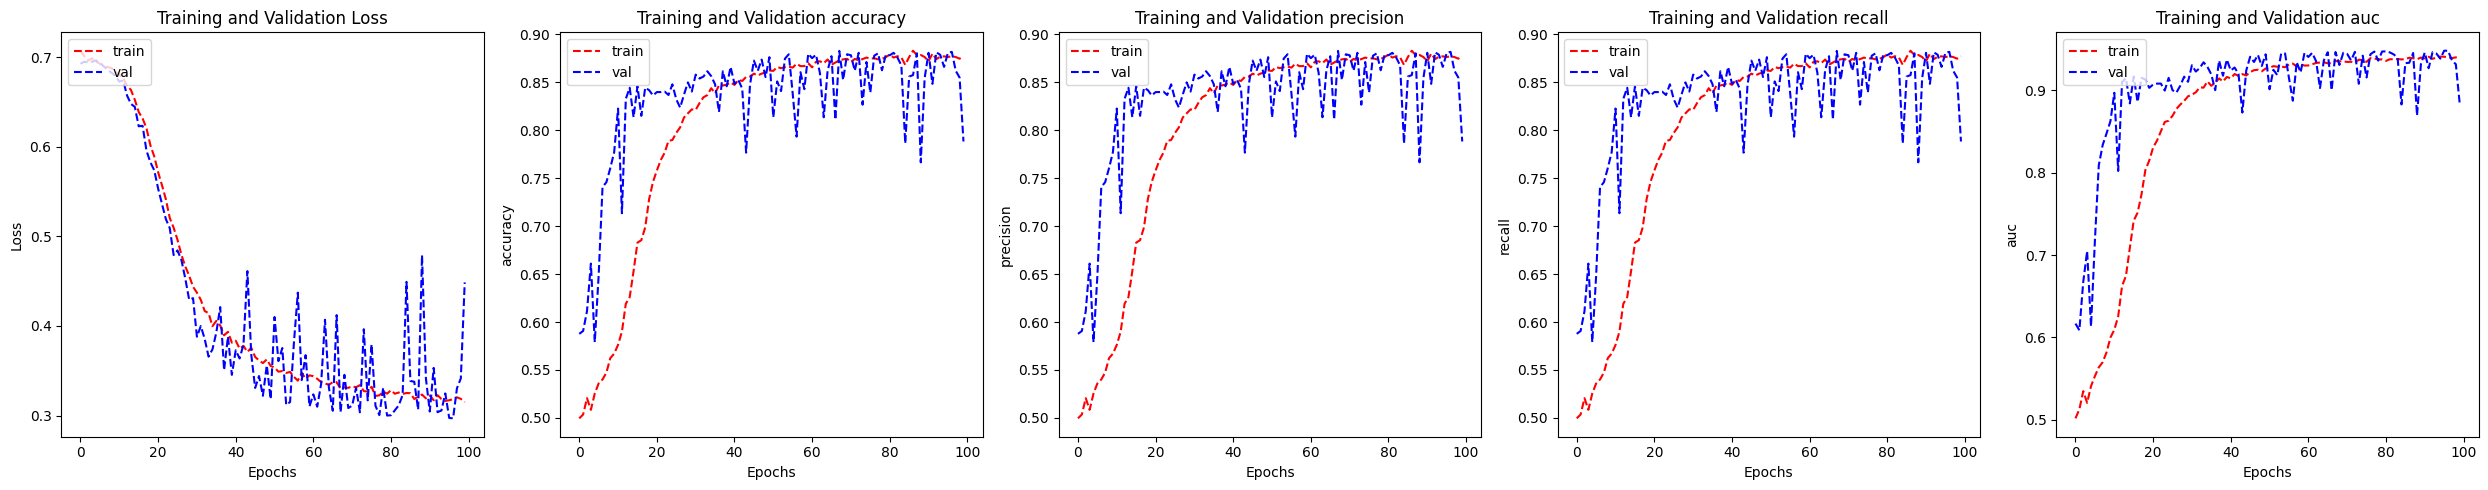

In [ ]:
# Plotting loss and metric learning curves to check for overfitting
plot_learning_curves(history_model_y1, ['accuracy', 'precision', 'recall', 'auc'])

**Baseline + L2 Regularisation + Dropout + No. of Neurons + Learning Rate Model (Tuned Model) Generalisation**

The improved model's learning curves above display less of a performance gap between the training and validation set. With a steady decrease in loss and less erratic spikes indicating stability within the validation set, the model shows no signs of overfitting or underfitting.

*The baseline parameter tuning included: L2 Regularisation, dropout, reduction of neurons, and learning rate.*

The implementation of dropout and regularisation within the model were the main contributors in improving generalisation of the model. A dropout rate of 0.25 in each convolutional layer, and a final strong rate 0.5 in the dense layer
allowed for the model to effectively drop random neurons in the convolutional layers, meaning that the model reduces the reliance on memorising the train data and thus can generalise more effectively. During model training, different values of dropout were tested and this lessened the performance gap between the train and validation set, however the validation set was erratic and still presented signs of overfitting.
After iterative training on L2 regularisation which balanced weights found that 0.01 regularisation along with dropout produced learning curves in all metrics that had little to no gap between the sets which is ideal. The instability within the validation set was improved by tuning the learning rate to 0.0001 from 0.001, this may explain that the model was skipping important data and so by further lessening the learning steps, the model is able to learn important information resulting in an almost ideal learning curves.

The number of neurons within the dense layer was also tuned down from 64 to 32 to reduce model complexity, because the model was previously overfitting.

The combination of the above parameters resulted in near idealistic learning curves that presented decent generalisation.

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Classification Report:

               precision    recall  f1-score   support

Non-cancerous       0.97      0.66      0.79      1163
    Cancerous       0.67      0.97      0.79       816

     accuracy                           0.79      1979
    macro avg       0.82      0.82      0.79      1979
 weighted avg       0.84      0.79      0.79      1979



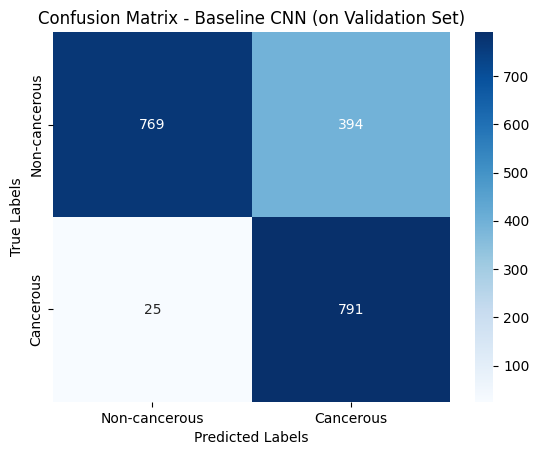

In [ ]:
#---------- Evaluating Param Tuned Model ----------
y1_val_probs = y1_cnn_model.predict(x_val) # model predicting on the validation set

# Convert one-hot predictions and labels to class indices
y1_val_pred = np.argmax(y1_val_probs, axis=1)
y1_val_true = np.argmax(y1_val, axis=1)

# Classification report
class_labels = ['Non-cancerous', 'Cancerous']
print("Classification Report:\n")
print(classification_report(y1_val_true, y1_val_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y1_val_true, y1_val_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Baseline CNN (on Validation Set)')
plt.show()

**Evaluation on the Tuned Model**

The process of hyperparameter tuning on the baseline model to improve performance was done iteratively. Whereby, each parameter was tuned on the model one at a time and evaluated to view it effects on the performance. After selecting the best performing rates for each parameter, a combination of parameters were specifically chosen to improve overfitting (which was the model's main issue) were included to the model and then evaluated and tuned again until an ideal generalisation and performance was achieved. The tuned parameters chosen were mentioned previously.

In order to **avoid patient-based data leakage**, the model is evaluated on a seperate validation set that simulates unseen data. Preventing the model to memorise specific patients cell patterns as it will fail to detect cancerous cases with unseen patients in the real world due to leakage. Another possible solution apart from splitting the data is augmenting the image data so that the model can learn images and still perform well on unseen data as the augmented images differ.

#### Final Model Evaluation for isCancerous

In [ ]:
#---------- Evaluating Final Model ON TEST SET----------
y1_test_probs = y1_cnn_model.predict(x_test) # final model predicting on test set

# Convert one-hot predictions and labels to class indices
y1_test_pred = np.argmax(y1_test_probs, axis=1)
y1_test_true = np.argmax(y1_test, axis=1)

# Classification report
class_labels = ['Non-cancerous', 'Cancerous']
print("Classification Report:\n")
print(classification_report(y1_test_true, y1_test_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y1_test_true, y1_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Baseline CNN (on Test Set)')
plt.show()

**Final isCancerous Model Evaluation**

This improvement in performance is due to the reduction of model complexity in the baseline by lessening the neurons and implementing regularisation and dropout to the model. Resulting in improved generalisation and therefore accurate/reliable performance.

** **
**Comparative Analysis**

**Final isCancerous Model vs. Baseline Model**

The final model displays a steadier increase in both train and validation sets in all metrics, with little spikes in the validation set as compared to the baseline model's learning curve with erratic instability and a performance gap. Although the baseline performance displays an overall high macro average of 0.88, it only indicates high performance specific to the train data. When evaluated on unseen data, this model will be deemed inaccurate and unreliable due to model overfit.
Whilst the tuned model has a slightly lower performance it can generalise well to unseen data whilst also accurately performing well in predicting classes. *This comparison between baseline and the final isCancerous model is **valid** due to using identical metrics, a combination of parameters contributed to the change in results, however lessening the learning rate was a main contributor to the improvement.*

<div align="center">

| Class          | Metric     | Baseline Model | Final isCancerous Model |
|----------------|------------|----------------|----------------|
| Non-cancerous  | Precision  | 0.91           | 0.93           |
|                | Recall     | 0.89           | 0.85           |
|                | F1 Score   | 0.90           | 0.89           |
| Cancerous      | Precision  | 0.85           | 0.81           |
|                | Recall     | 0.87           | 0.91           |
|                | F1 Score   | 0.86           | 0.86           |
| **Overall**    | Accuracy   | 0.88           | 0.88           |
|                | Macro Avg  | 0.88           | 0.87           |
| Generalisation |            | Overfitting    | Fitting well   

</div>


**Final isCancerous Model vs Academic Literature**

The academic literature by Sirinukunwattana et al., proposes detection and classification techniques of nuclei. The research paper classifies each detected nucleus into one of the 4 classes of Epithelial, Inflammatory, Fibroblast, and Miscellaneous using 4 different models. Whereby the epithelial nucleus class is the only cancerous nuclei within this study.
Since my final isCancerous model is a binary classification detecting if the cell is cancerous or not, an average of all the literature's model's F1-score for the 3 non-cancerous nucleus (inflammatory, fibroblast, and miscellaneous) will be compared against my models "non-cancerous" F1-score. The literature's f1-score for classifying the epithelial nuclei will be compared against my model's "cancerous" f1-score. Figure 7 and table III in the literature is used to compare results with my final model.

<div align="center">
Classifying Cancerous

|                     | Model                   | F1-Score       |
|---------------------|-------------------------|----------------|
| My Model            | Final isCancerous Model | 0.86           |
| Academic Literature | Softmax CNN + SSPP      | 0.85           |
|                     | Softmax CNN + NEP       | 0.88           |
|                     | Superpixel descriptor   | 0.80           |
|                     | CRImage                 | 0.49           |
</div>

The literature's softmax CNN + NEP  model performs slightly better in classifying cancerous cells in the data leading by 0.02, however comparison is limited due to comparison only on f1-score for all models.

<div align="center">
Classifying Non-cancerous

|                     | Model                   | F1-Score       |
|---------------------|-------------------------|----------------|
| My Model            | Final isCancerous Model | 0.89           |
| Academic Literature | Softmax CNN + SSPP      | 0.63           |
|                     | Softmax CNN + NEP       | 0.68           |
|                     | Superpixel descriptor   | 0.56           |
|                     | CRImage                 | 0.40           |
</div>

My final isCancerous model performs the best for classifying non-cancerous cells with an f1-score of 0.89, followed by the literature's softmax CNN + NEP model with 0.68.

My final isCancerous model performed similarly to the literature's softmax CNN + NEP model in classifying cancerous cells, however my model greatly exceeded the performance amongst the literature's models for classifying non-cancerous cells based on f1-scores. This **may be misleading or unfair** as the comparison is limited in metrics, although the literature also uses precision, recall and auc as metrics, its performance and results are determined by the f1-score of their models, thus limited to only f1-score.

### Task 2: Classifying Cell Type
**Author: Joelle**

In [ ]:
# TODO talk about thought process here
# TODO @ Joelle Talk about base model selection

#### Model Building (Baseline)

In [ ]:
# Extracted from course content

# Build the model
y2_baseline_model = Sequential()

# Block 1
y2_baseline_model.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
y2_baseline_model.add(Activation('relu'))
y2_baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
y2_baseline_model.add(Conv2D(64, (3, 3)))
y2_baseline_model.add(Activation('relu'))
y2_baseline_model.add(MaxPooling2D(pool_size=(2, 2)))

# Classification head
y2_baseline_model.add(Flatten())              # Flatten the output for the dense layer
y2_baseline_model.add(Dense(64))              # Dense layer with 64 units
y2_baseline_model.add(Activation('relu'))
y2_baseline_model.add(Dense(4))               # 4 output classes for cellTypeName
y2_baseline_model.add(Activation('softmax'))  # Softmax for multi-class classification

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)  # Instantiate Adam optimizer
y2_baseline_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,  # Use the instantiated optimizer here
              metrics=['accuracy',
                              metrics.Precision(name='precision'),
                              metrics.Recall(name='recall'),
                              metrics.AUC(name='auc')]
                     )

early_stop = EarlyStopping(
    monitor='val_loss',     # What to monitor (you can use 'val_accuracy' too)
    patience=5,             # Stop if no improvement for 5 consecutive epochs
    restore_best_weights=True,  # Revert to best weights
    verbose=1
)

# Fit the model to the data
history_baseline_y2 = y2_baseline_model.fit(x_train, y2_train, epochs=100,  # Number of epochs to train
          batch_size=32,  # Size of the batches for each training step
          validation_data=(x_val, y2_val),  # Validation data (optional, but recommended)
          callbacks=[early_stop],
          verbose=1  # Show progress bar during training (0 = silent, 1 = progress bar)
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4678 - auc: 0.7115 - loss: 1.2152 - precision: 0.5773 - recall: 0.1318 - val_accuracy: 0.6812 - val_auc: 0.8820 - val_loss: 0.8459 - val_precision: 0.7849 - val_recall: 0.5144
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6852 - auc: 0.8879 - loss: 0.8160 - precision: 0.7757 - recall: 0.5569 - val_accuracy: 0.6352 - val_auc: 0.8577 - val_loss: 0.9093 - val_precision: 0.7283 - val_recall: 0.5093
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6880 - auc: 0.8897 - loss: 0.8009 - precision: 0.7684 - recall: 0.5824 - val_accuracy: 0.7135 - val_auc: 0.9096 - val_loss: 0.7296 - val_precision: 0.8022 - val_recall: 0.6331
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7201 - auc: 0.9110 - loss: 0.7221 - precision: 0.7934 - recall: 0.6360 - val_accuracy: 0.7211 - val_auc: 0.9127 - val_loss: 0.7149 - val_precision: 0.7887 - val_recall: 0.6564
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# For validation set evaluation
val_loss, val_accuracy, val_precision, val_recall, val_auc = y2_baseline_model.evaluate(x_val, y2_val, verbose=1)

# Calculate F1-score manually
if (val_precision + val_recall) != 0:
    val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
else:
    val_f1_score = 0.0 # Handle division by zero if precision and recall are both zero

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Precision: {val_precision:.4f}')
print(f'Validation Recall: {val_recall:.4f}')
print(f'Validation AUC: {val_auc:.4f}') # Now correctly named
print(f'Validation F1 Score: {val_f1_score:.4f}')

# For test set evaluation
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = y2_baseline_model.evaluate(x_test, y2_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}') # Good to print test loss too
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1 Score: {test_f1_score:.4f}')

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_pred = y2_baseline_model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y2_val, axis=1)

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7456 - auc: 0.9186 - loss: 0.6945 - precision: 0.7874 - recall: 0.6958
Validation Loss: 0.6592
Validation Accuracy: 0.7509
Validation Precision: 0.7966
Validation Recall: 0.7044
Validation AUC: 0.9260
Validation F1 Score: 0.7477
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7380 - auc: 0.9190 - loss: 0.6980 - precision: 0.7744 - recall: 0.6876
Test Loss: 0.6700
Test Accuracy: 0.7434
Test Precision: 0.7854
Test Recall: 0.6970
Test F1 Score: 0.9244
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[253  48  63  24]
 [ 30 394  55  24]
 [ 22  40 749   5]
 [ 50  89  43  90]]
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       388
           1       0.69      0.78      0.73       503
           2       0.82      0.92      0.87       816
           3       0.63      0.33      0.43       272

    accuracy                           0.75      1979
   macro avg       0.71      0.67      0.68   

In [ ]:
# --- Test Set Evaluation (Baseline Model) ---
print("\n--- Evaluating Baseline Model on Test Data ---")
test_loss, test_accuracy, test_precision, test_recall, test_auc = y2_baseline_model.evaluate(x_test, y2_test, verbose=1)

# Calculate F1-score manually for test set (Micro-averaged)
if (test_precision + test_recall) != 0:
    test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
else:
    test_f1_score = 0.0 # Handle division by zero if precision and recall are both zero

print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test AUC: {test_auc:.4f}') # Added Test AUC print
print(f'Test F1 Score (Micro-Avg): {test_f1_score:.4f}')

# Generate predictions and reports for test set
y_pred_test_baseline = y2_baseline_model.predict(x_test)
y_pred_classes_test_baseline = np.argmax(y_pred_test_baseline, axis=1)
y_true_test_baseline = np.argmax(y2_test, axis=1) # Ensure y2_test is used here

print("\n--- Confusion Matrix (Baseline Model - Test Data) ---")
print(confusion_matrix(y_true_test_baseline, y_pred_classes_test_baseline))

print("\n--- Classification Report (Baseline Model - Test Data) ---")
print(classification_report(y_true_test_baseline, y_pred_classes_test_baseline))


--- Evaluating Baseline Model on Test Data ---
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7380 - auc: 0.9190 - loss: 0.6980 - precision: 0.7744 - recall: 0.6876

Test Loss: 0.6700
Test Accuracy: 0.7434
Test Precision: 0.7854
Test Recall: 0.6970
Test AUC: 0.9244
Test F1 Score (Micro-Avg): 0.7386
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Confusion Matrix (Baseline Model - Test Data) ---
[[248  36  61  19]
 [ 34 369  61  31]
 [ 11  39 766   0]
 [ 71 102  43  89]]

--- Classification Report (Baseline Model - Test Data) ---
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       364
           1       0.68      0.75      0.71       495
           2       0.82      0.94      0.88       816
           3       0.64      0.29      0.40       305

    accuracy                           0.74      1980
   macro avg       0.71      0.66      0.67      1980
weighted avg       0.73      0.74      0.73      1980



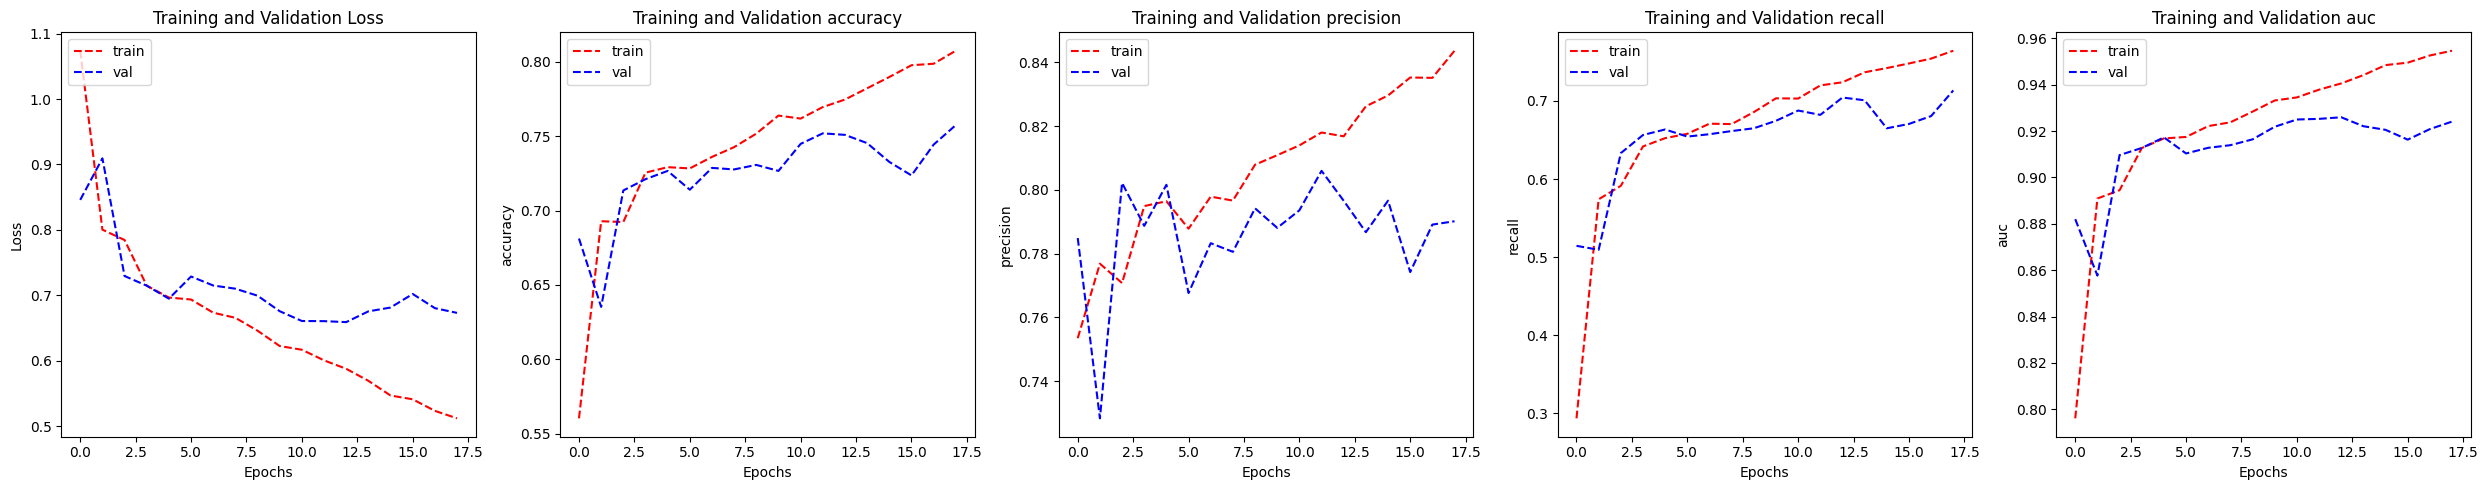

In [ ]:
plot_learning_curves(history_baseline_y2, ['accuracy', 'precision', 'recall', 'auc'])

In [ ]:
# Save baseline model evaluation report to file
filename_baseline = 'classification_report_baseline.txt'
with open(filename_baseline, 'w') as f:
    f.write("--- Confusion Matrix (Baseline Model) ---\n")
    f.write(str(confusion_matrix(y_true, y_pred_classes)))
    f.write("\n\n--- Classification Report (Baseline Model) ---\n")
    f.write(classification_report(y_true, y_pred_classes))

print(f"Classification report saved at: {os.path.abspath(filename_baseline)}")

try:
    from google.colab import files
    files.download(filename_baseline)
except ImportError:
    print("Not running in Colab or 'files' module unavailable, skipping download.")


Classification report saved at: /content/classification_report_baseline.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y2_baseline_model.save('baseline_y2_model.keras')

#### Model Training (Parameter Tuning)

In [ ]:
# TODO @JOELLE write how i handled class imbalance and talk about techniques augmentation

In [ ]:
# TODO Algorithm configuration chosen hyperparameter
# TODO overfit ( learning curves after ), drop out to improve generalization, validation sert and outlines parameter tuning appraoaches
# todo use graphs to show

Parameter Tuning Process to get final model

In [ ]:
# TODO Talk about process here

Final Model
(CNN with Data Augmentation and Class Weighting)

In [ ]:
# --- Final Model - CellType Classification  ---

# --- Verify Data ---
print(f"x_train shape: {x_train.shape}, dtype: {x_train.dtype}")
print(f"y2_train shape: {y2_train.shape}, dtype: {y2_train.dtype}")
print(f"x_val shape: {x_val.shape}, dtype: {x_val.dtype}")
print(f"y2_val shape: {y2_val.shape}, dtype: {y2_val.dtype}")
print(f"x_train min/max before generator: {np.min(x_train)}, {np.max(x_train)}")

# --- Early Stopping ---
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  #BIGGER PATIENCE

# --- Class Weights ---
y_train_labels = np.argmax(y2_train, axis=1)
calculated_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(calculated_class_weights))
print("Calculated Class Weights:", class_weights_dict)

# --- Data Augmentation ---
train_datagen = ImageDataGenerator( # BIGGER ROTATION
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()  # No rescale needed

# --- Model Architecture ---
y2_final_model = Sequential()
y2_final_model.add(Conv2D(32, (3, 3), input_shape=(27, 27, 3)))
y2_final_model.add(Activation('relu'))
y2_final_model.add(MaxPooling2D(pool_size=(2, 2)))
y2_final_model.add(Dropout(0.25))

y2_final_model.add(Conv2D(64, (3, 3)))
y2_final_model.add(Activation('relu'))
y2_final_model.add(MaxPooling2D(pool_size=(2, 2)))
y2_final_model.add(Dropout(0.25))

y2_final_model.add(Flatten())
y2_final_model.add(Dense(64))
y2_final_model.add(Activation('relu'))
y2_final_model.add(Dropout(0.5)) # DROP OUT IS SAME
y2_final_model.add(Dense(4))
y2_final_model.add(Activation('softmax'))

# --- Compile ---
optimizer_final = Adam(learning_rate=0.001) # SAME
y2_final_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer_final,
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)
y2_final_model.summary()

# --- Training ---
BATCH_SIZE = 32
steps_per_epoch = int(np.ceil(len(x_train) / BATCH_SIZE))
validation_steps = int(np.ceil(len(x_val) / BATCH_SIZE))

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

history_final_y2 = y2_final_model.fit(
    train_datagen.flow(x_train, y2_train, batch_size=BATCH_SIZE),
    steps_per_epoch=steps_per_epoch,
    epochs=100, # CHANGED TO 100
    validation_data=val_datagen.flow(x_val, y2_val, batch_size=BATCH_SIZE),
    validation_steps=validation_steps,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)


x_train shape: (5937, 27, 27, 3), dtype: float32
y2_train shape: (5937, 4), dtype: float64
x_val shape: (1979, 27, 27, 3), dtype: float32
y2_val shape: (1979, 4), dtype: float64
x_train min/max before generator: 0.0, 1.0
Calculated Class Weights: {0: np.float64(1.3065580985915493), 1: np.float64(0.9606796116504854), 2: np.float64(0.606559051900286), 3: np.float64(1.834672435105068)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 25, 25, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,116 (477.02 KB)

 Trainable params: 122,116 (477.02 KB)

 Non-trainable params: 0 (0.00 B)

Steps per epoch: 186
Validation steps: 62
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.3672 - auc: 0.6067 - loss: 1.3499 - precision: 0.5638 - recall: 0.0466 - val_accuracy: 0.5760 - val_auc: 0.8272 - val_loss: 1.0486 - val_precision: 0.9114 - val_recall: 0.1976
Epoch 2/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5750 - auc: 0.8105 - loss: 1.1211 - precision: 0.7676 - recall: 0.2845 - val_accuracy: 0.6781 - val_auc: 0.8862 - val_loss: 0.8532 - val_precision: 0.8294 - val_recall: 0.4816
Epoch 3/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6253 - auc: 0.8438 - loss: 1.0406 - precision: 0.7652 - recall: 0.3907 - val_accuracy: 0.6958 - val_auc: 0.8967 - val_loss: 0.8038 - val_precision: 0.8368 - val_recall: 0.5154
Epoch 4/100
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6549 - auc: 0.8596 - loss: 0.9821 - precision: 0.7772 - recall: 0.4508 - val_accuracy: 0.6832 - val_auc: 0.8796 - val_loss: 0.8510 - val_precision: 0.8049 - val_recall: 0.5296
Epoch 5/100
186/186 ━━━━━━━━━━━━━━━

In [ ]:
# --- Evaluation ---
print("\n--- Evaluating Final Model ---")
loss_final, acc_final, prec_final, rec_final, auc_final = y2_final_model.evaluate(x_val, y2_val, verbose=1)
print(f'Validation Loss (Final): {loss_final:.4f}')
print(f'Validation Accuracy (Final): {acc_final:.4f}')
print(f'Validation Precision (Final): {prec_final:.4f}')
print(f'Validation Recall (Final): {rec_final:.4f}')
print(f'Validation AUC (Final): {auc_final:.4f}')

# --- Predictions & Reports ---
y2_pred_final = y2_final_model.predict(x_val)
y2_pred_classes_final = np.argmax(y2_pred_final, axis=1)
y2_true_classes_final = np.argmax(y2_val, axis=1)

print("\n--- Confusion Matrix (Final Model) ---")
print(confusion_matrix(y2_true_classes_final, y2_pred_classes_final))

print("\n--- Classification Report (Final Model) ---")
print(classification_report(y2_true_classes_final, y2_pred_classes_final))

# --- Save the model ---
y2_final_model.save('y2_final_model.keras')


--- Evaluating Final Model ---
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7647 - auc: 0.9346 - loss: 0.6151 - precision: 0.8206 - recall: 0.6969
Validation Loss (Final): 0.5811
Validation Accuracy (Final): 0.7731
Validation Precision (Final): 0.8354
Validation Recall (Final): 0.7105
Validation AUC (Final): 0.9426
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Confusion Matrix (Final Model) ---
[[261  51  53  23]
 [ 34 400  34  35]
 [ 25  53 730   8]
 [ 33  80  20 139]]

--- Classification Report (Final Model) ---
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       388
           1       0.68      0.80      0.74       503
           2       0.87      0.89      0.88       816
           3       0.68      0.51      0.58       272

    accuracy                           0.77      1979
   macro avg       0.74      0.72      0.73      1979
weighted avg       0.77      0.77      0.77      1979



In [ ]:
# --- Test Set Evaluation for Final Model ---
print("\n--- Evaluating Final Model on Test Data ---") # Updated title
loss_final_test, acc_final_test, prec_final_test, rec_final_test, auc_final_test = y2_final_model.evaluate(x_test, y2_test, verbose=1)

# Print Test Metrics for Final Model
print(f'\nTest Loss (Final Model): {loss_final_test:.4f}')
print(f'Test Accuracy (Final Model): {acc_final_test:.4f}')
print(f'Test Precision (Final Model): {prec_final_test:.4f}')
print(f'Test Recall (Final Model): {rec_final_test:.4f}')
print(f'Test AUC (Final Model): {auc_final_test:.4f}')

# --- Generate Predictions for Final Model Test Report ---
# Ensure predictions are made on the TEST data
y2_pred_final_test = y2_final_model.predict(x_test)
y2_pred_classes_final_test = np.argmax(y2_pred_final_test, axis=1)
y2_true_classes_final_test = np.argmax(y2_test, axis=1) # Ensure y2_test is used here

print("\n--- Confusion Matrix (Final Model - Test Data) ---") # Updated title
print(confusion_matrix(y2_true_classes_final_test, y2_pred_classes_final_test))

print("\n--- Classification Report (Final Model - Test Data) ---") # Updated title
print(classification_report(y2_true_classes_final_test, y2_pred_classes_final_test))



--- Evaluating Final Model on Test Data ---
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7789 - auc: 0.9453 - loss: 0.5692 - precision: 0.8428 - recall: 0.7322

Test Loss (Final Model): 0.5565
Test Accuracy (Final Model): 0.7768
Test Precision (Final Model): 0.8383
Test Recall (Final Model): 0.7253
Test AUC (Final Model): 0.9476
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Confusion Matrix (Final Model - Test Data) ---
[[270  28  50  16]
 [ 33 393  33  36]
 [ 16  50 742   8]
 [ 58  82  32 133]]

--- Classification Report (Final Model - Test Data) ---
              precision    recall  f1-score   support

           0       0.72      0.74      0.73       364
           1       0.71      0.79      0.75       495
           2       0.87      0.91      0.89       816
           3       0.69      0.44      0.53       305

    accuracy                           0.78      1980
   macro avg       0.75      0.72      0.72      1980
weighted avg       0.77      0.78      0.77      1980


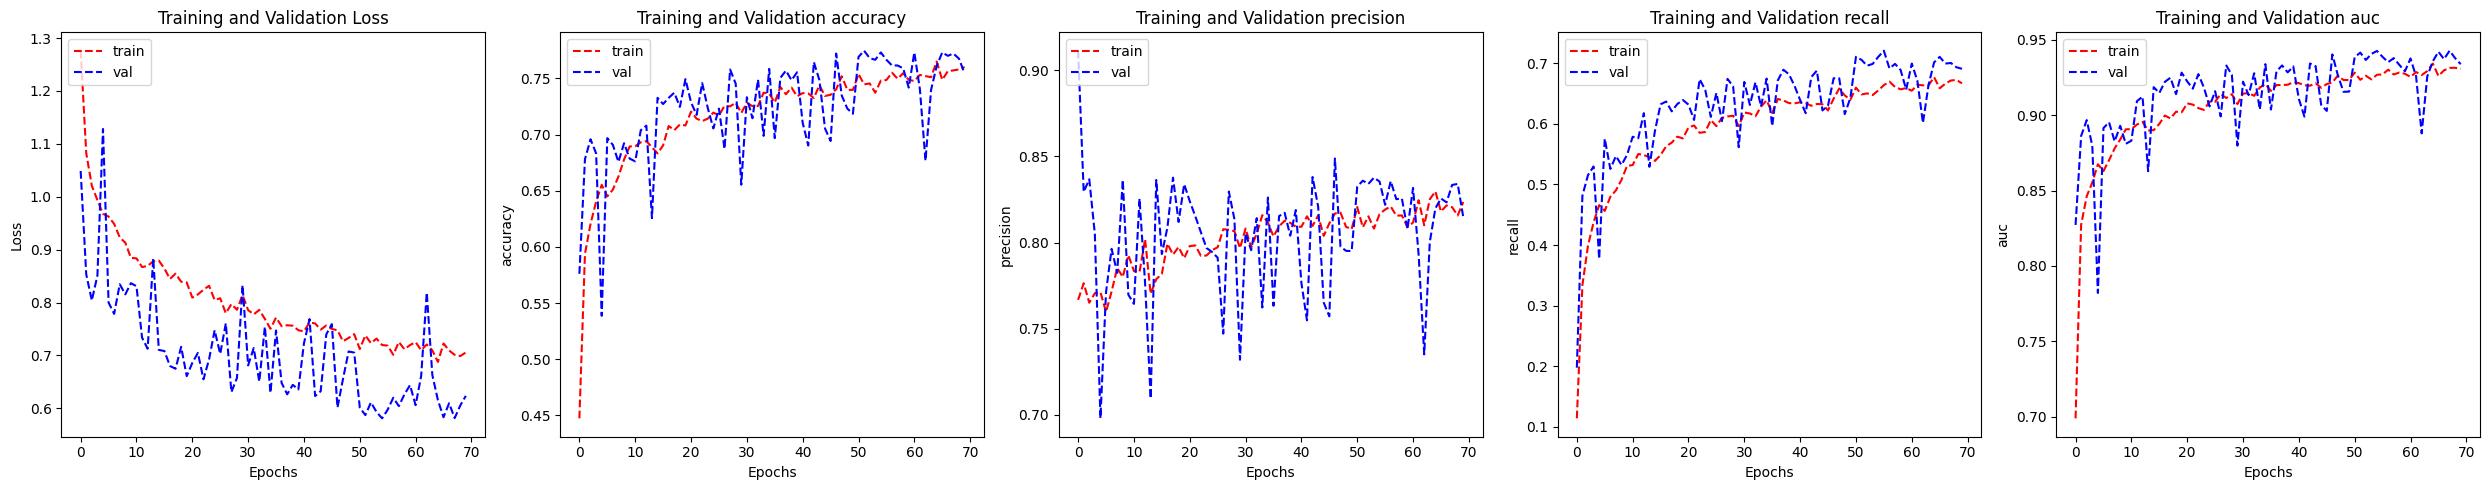

In [ ]:
plot_learning_curves(history_final_y2, ['accuracy', 'precision', 'recall', 'auc'])

In [ ]:
# Save to file
filename_final = 'classification_report_final.txt'
with open(filename_final, 'w') as f:
    f.write("--- Confusion Matrix (Final Model) ---\n")
    f.write(str(confusion_matrix(y2_true_classes_final, y2_pred_classes_final)))
    f.write("\n\n--- Classification Report (Final Model) ---\n")
    f.write(classification_report(y2_true_classes_final, y2_pred_classes_final))

print(f"Classification report saved at: {os.path.abspath(filename_final)}")

try:
    from google.colab import files
    files.download(filename_final)
except ImportError:
    print("Not running in Colab or 'files' module unavailable, skipping download.")


Classification report saved at: /content/classification_report_final.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# clearly show the improved accuracy and provide justification
# show how well the model is generalized and test on different subsets

# *Critical Discussion on Semi-supervised learning (SSL)*

[ The core principles of Semi-supervised learning were taken from ML Lab Practicals "Introduction to Semi-Supervised Learning with CNN" ]

### **Insightful Discussion**
Definition :- It is a branch of machine learning that combines labeled and unlabeled data to train a model more effectively than using labeled data on it's own. It lies in between supervised and unsupervised learning.

**How it applies to the this classification project using the extra data given :-**

  Main dataset: contains labeled data — cellType and isCancerous

  Extra dataset: only has isCancerous — cellType is missing (the problem)

1.   Train a model using the labeled main data (X_train, y2_train)
2.   Use this model to predict pseudo-labels (e.g., estimated cellType) for the extra data (x_extra_train)
3. Add the confidently predicted samples to your training set
4. Retrain the model on this expanded dataset

>   This allows the model to learn from a larger dataset without requiring manual labeling of the extra data.

**Strengths and Limitation of Semi- Supervised Learning**

| Strengths                                   | Why It Matters                                                                 |
|---------------------------------------------|---------------------------------------------------------------------------------|
| Improves accuracy with less manual labeling | Leverages the extra data without needing `cellType` labels                      |
| Makes use of all available data             | Enhances training with both main and extra datasets                             |
| Better generalization                       | Reduces overfitting by exposing model to more variability                      |
| Cost-effective                              | Saves time and effort compared to manual annotation                             |

----

| Limitations                                  | Impact                                                                         |
|----------------------------------------------|--------------------------------------------------------------------------------|
| Pseudo-label noise                           | Incorrect predictions on extra data may introduce wrong labels                 |
| Confidence threshold tuning is tricky        | Low threshold adds noise; high threshold may exclude useful samples            |
| Class imbalance can worsen                   | Over-represented classes might dominate pseudo-labeled data                    |
| Depends on initial supervised model quality  | Poor initial model results in low-quality pseudo-labels                        |

### **Real-world Applicability**

E-commerce	Product categorization and customer intent prediction with minimal labeled data and user behavior logs (e.g., sequence of actions while browsing) as unlabeled input. If the user tends to search for "running shoes" and filter by a particular size then adds the item to cart the SSL model can imply the customer's purchase intent even if its not explicitly labeled.

SSL methods to boost task performance in this use case: Pseudo-labelling, by training an initial model on the few labeled products, the model can be used to predict categories for unlabeled products. Predictions with  high confidence are added to the labeled set for retraining.


Semi-Supervised Approach

In [ ]:
# Image and dataset loaded above
# Image resized 27x27 and pixels are normalized

# Pre-processing Extra Data
# --- Filter extra data to include only valid isCancerous labels (0 or 1)
extra_filtered = df_extra[df_extra['isCancerous'].isin([0, 1])].copy()

# --- One-hot encode isCancerous
y_extra_isCancerous = to_categorical(extra_filtered['isCancerous'].values, num_classes=2)

# --- Add image paths using the same image_dir (make sure it's defined)
extra_filtered['ImagePath'] = extra_filtered['ImageName'].apply(lambda x: os.path.join(image_dir, x))

# --- Split into "unlabeled" train and hold-out test for pseudo-label evaluation
# Note: You're splitting image paths here, not the loaded images directly.
extra_unlabeled_train_paths, extra_unlabeled_test_paths = train_test_split(
    extra_filtered['ImagePath'].values,
    test_size=0.2,
    stratify=extra_filtered['isCancerous'],
    random_state=42
)

# --- Load image data using your existing load_images function
x_extra_unlabeled = load_images(extra_unlabeled_train_paths)
x_extra_unlabeled_test = load_images(extra_unlabeled_test_paths)

# --- Create dummy `cellType` labels (all -1, indicating unlabeled)
# to merge with labeled main data later on
# creates a brand new numPy array where every single element of y_extra_cellType has no labels from the start
y_extra_cellType = np.full(len(extra_filtered), fill_value=-1)

# use x_extra_unlabeled and assign pseudo-labels from the trained model,
# then combine with labeled data for semi-supervised learning

# --- Load your final supervised model ---
# use final model saved as 'y2_final_model.keras'
cnn_supervised = load_model("y2_final_model.keras")

# --- Evaluate Fully Supervised Model ---
# Ensure X_test_filtered and y_test_filtered are correctly defined and loaded
# Use test set for the 'cellType' task from main dataset
supervised_score = cnn_supervised.evaluate(x_test, y2_test, verbose=0)[1]
print(f"Fully Supervised Test Accuracy: {supervised_score:.2f}")

Fully Supervised Test Accuracy: 0.78


Semi-Supervised Fine Tuning with Pesudo-Labels

In [ ]:
# --- PREPROCESSING + SEMI-SUPERVISED PIPELINE SETUP ---

# --- Generate Pseudo-labels ---
print(f"\nPredicting pseudo-labels for {len(x_extra_unlabeled)} samples...")
unlabeled_probabilities = cnn_supervised.predict(x_extra_unlabeled)

CONFIDENCE_THRESHOLD = 0.90
predicted_classes_unlabeled = np.argmax(unlabeled_probabilities, axis=1)
max_probabilities = np.max(unlabeled_probabilities, axis=1)
confident_mask = max_probabilities >= CONFIDENCE_THRESHOLD

x_confident_unlabeled = x_extra_unlabeled[confident_mask]
y_pseudo_labels = predicted_classes_unlabeled[confident_mask]
y_pseudo_labels_one_hot = to_categorical(y_pseudo_labels, num_classes=4)

print(f"Found {len(x_confident_unlabeled)} confident pseudo-labeled samples.")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"Pseudo-label distribution: {np.bincount(y_pseudo_labels)}")

# --- Combine with original labeled data ---
x_train_combined = np.concatenate((x_train, x_confident_unlabeled), axis=0)
y_train_combined = np.concatenate((y2_train, y_pseudo_labels_one_hot), axis=0)

print(f"\nCombined training size: {len(x_train_combined)}")
print(f"Labeled: {len(x_train)}, Pseudo-labeled: {len(x_confident_unlabeled)}")

# ---  Fine-tune the model ---
semi_supervised_model = load_model('y2_final_model.keras')  # Reload fresh copy

semi_supervised_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        metrics.AUC(name='auc')
    ]
)

# --- Data Augmentation ---
train_datagen_combined = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# --- Compute class weights ---
combined_class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(np.argmax(y_train_combined, axis=1)),
    y=np.argmax(y_train_combined, axis=1)
)
combined_class_weights_dict = dict(enumerate(combined_class_weights))

# --- Train model ---
history_semi_supervised = semi_supervised_model.fit(
    train_datagen_combined.flow(x_train_combined, y_train_combined, batch_size=32),
    epochs=100,
    validation_data=(x_val, y2_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    class_weight=combined_class_weights_dict
)



Predicting pseudo-labels for 8307 samples...
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Found 3474 confident pseudo-labeled samples.
Confidence threshold: 0.9
Pseudo-label distribution: [  18  275 3181]

Combined training size: 9411
Labeled: 5937, Pseudo-labeled: 3474
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


295/295 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8391 - auc: 0.9660 - loss: 0.6111 - precision: 0.8829 - recall: 0.7905 - val_accuracy: 0.7014 - val_auc: 0.9059 - val_loss: 0.7554 - val_precision: 0.7575 - val_recall: 0.6473
Epoch 2/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8266 - auc: 0.9603 - loss: 0.6223 - precision: 0.8739 - recall: 0.7775 - val_accuracy: 0.7524 - val_auc: 0.9315 - val_loss: 0.6352 - val_precision: 0.8027 - val_recall: 0.6968
Epoch 3/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8293 - auc: 0.9618 - loss: 0.6269 - precision: 0.8734 - recall: 0.7755 - val_accuracy: 0.7686 - val_auc: 0.9394 - val_loss: 0.5952 - val_precision: 0.8332 - val_recall: 0.7044
Epoch 4/100
295/295 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8401 - auc: 0.9653 - loss: 0.5917 - precision: 0.8851 - recall: 0.7941 - val_accuracy: 0.7453 - val_auc: 0.9268 - val_loss: 0.6578 - val_precision: 0.8008 - val_recall: 0.6806
Epoch 5/100
295/295 ━━━━━━━━━━━━━━━

In [ ]:
# --- Final Evaluation ---
# print("\n--- Evaluating Fine-Tuned Semi-Supervised Model ---")
# loss_semi, acc_semi = semi_supervised_model.evaluate(x_test, y2_test, verbose=0)

loss_semi, acc_semi, prec_semi, rec_semi, auc_semi = semi_supervised_model.evaluate(x_val, y2_val, verbose=1)

# --- 3. Print the AUC ---
print(f'\nValidation Loss (Semi): {loss_semi:.4f}')
print(f'Validation Accuracy (Semi): {acc_semi:.4f}')
print(f'Validation Precision (Semi): {prec_semi:.4f}')
print(f'Validation Recall (Semi): {rec_semi:.4f}')
print(f'Validation AUC (Semi): {auc_semi:.4f}') #  Multiclass AUC

# --- Classification Report ---
y_pred_semi = semi_supervised_model.predict(x_test)
y_pred_classes_semi = np.argmax(y_pred_semi, axis=1)
y_true_classes_semi = np.argmax(y2_test, axis=1)

print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_true_classes_semi, y_pred_classes_semi))

print("\n--- Classification Report ---")
print(classification_report(y_true_classes_semi, y_pred_classes_semi))

# --- Save Model ---
semi_supervised_model.save('semi_supervised_y2_model.keras')
print("Saved: semi_supervised_y2_model.keras")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7586 - auc: 0.9344 - loss: 0.6174 - precision: 0.8197 - recall: 0.6923

Validation Loss (Semi): 0.5913
Validation Accuracy (Semi): 0.7726
Validation Precision (Semi): 0.8312
Validation Recall (Semi): 0.7064
Validation AUC (Semi): 0.9402
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

--- Confusion Matrix ---
[[285  28  39  12]
 [ 31 414  15  35]
 [ 26  63 716  11]
 [ 56  85  18 146]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       364
           1       0.70      0.84      0.76       495
           2       0.91      0.88      0.89       816
           3       0.72      0.48      0.57       305

    accuracy                           0.79      1980
   macro avg       0.76      0.74      0.74      1980
weighted avg       0.79      0.79      0.78      1980

Saved: semi_supervised_y2_model.keras


In [ ]:
# --- Test Set Evaluation ---
print("\n--- Evaluating Semi-Supervised Model on Test Data ---") # Updated title
loss_test, acc_test, prec_test, rec_test, auc_test = semi_supervised_model.evaluate(x_test, y2_test, verbose=1)

# --- Print Test Metrics ---
print(f'\nTest Loss: {loss_test:.4f}')
print(f'Test Accuracy: {acc_test:.4f}')
print(f'Test Precision: {prec_test:.4f}')
print(f'Test Recall: {rec_test:.4f}')
print(f'Test AUC: {auc_test:.4f}')

# --- Generate Predictions for Test Report ---
# Ensure predictions are made on the TEST data
y_pred_test = semi_supervised_model.predict(x_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_true_classes_test = np.argmax(y2_test, axis=1) # Ensure y2_test is used here

print("\n--- Confusion Matrix (Test Data) ---")  # Updated title
print(confusion_matrix(y_true_classes_test, y_pred_classes_test))

print("\n--- Classification Report (Test Data) ---") # Updated title
print(classification_report(y_true_classes_test, y_pred_classes_test))


--- Evaluating Semi-Supervised Model on Test Data ---
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7913 - auc: 0.9442 - loss: 0.5778 - precision: 0.8398 - recall: 0.7350

Test Loss: 0.5638
Test Accuracy: 0.7884
Test Precision: 0.8390
Test Recall: 0.7288
Test AUC: 0.9468
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Confusion Matrix (Test Data) ---
[[285  28  39  12]
 [ 31 414  15  35]
 [ 26  63 716  11]
 [ 56  85  18 146]]

--- Classification Report (Test Data) ---
              precision    recall  f1-score   support

           0       0.72      0.78      0.75       364
           1       0.70      0.84      0.76       495
           2       0.91      0.88      0.89       816
           3       0.72      0.48      0.57       305

    accuracy                           0.79      1980
   macro avg       0.76      0.74      0.74      1980
weighted avg       0.79      0.79      0.78      1980



In [ ]:
with open('classification_report_semi.txt', 'w') as f:
    f.write("--- Confusion Matrix ---\n")
    f.write(str(confusion_matrix(y_true_classes_semi, y_pred_classes_semi)))
    f.write("\n\n--- Classification Report (Semi with Final Model)---\n")
    f.write(classification_report(y_true_classes_semi, y_pred_classes_semi))
import os
print("Saving file in directory:", os.getcwd())
from google.colab import files

files.download('classification_report_semi.txt')

Saving file in directory: /content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Evaluation

In [ ]:
# TODO write justifications of all models used and baseline vs final
# do comparative analysis here
# be fair and consistent
# move this below semi supervised classification

| Class | Metric    | Baseline Model | Final Supervised | Semi-Supervised |
| :---- | :-------- | :------------- | :--------------- | :-------------- |
| **0** | Precision | 0.64           | 0.70             | **0.72**        |
|       | Recall    | 0.75           | 0.73             | **0.77**        |
|       | F1-score  | 0.69           | 0.71             | **0.74**        |
| **1** | Precision | 0.74           | **0.73**         | 0.69            |
|       | Recall    | 0.74           | 0.74             | **0.83**        |
|       | F1-score  | 0.74           | 0.73             | **0.75**        |
| **2** | Precision | 0.84           | 0.89             | **0.93**        |
|       | Recall    | **0.92**       | 0.90             | 0.84            |
|       | F1-score  | 0.88           | **0.90**         | 0.88            |
| **3** | Precision | **0.66**       | 0.61             | 0.62            |
|       | Recall    | 0.29           | **0.57**         | 0.53            |
|       | F1-score  | 0.41           | **0.59**         | 0.57            |

| Metric          | Baseline Model | Final Supervised | Semi-Supervised |
| --------------- | -------------- | ---------------- | --------------- |
| Accuracy        | 0.75           | **0.78**         | **0.78**        |
| Macro Avg F1    | 0.68           | 0.73             | **0.74**        |
| Weighted Avg F1 | 0.74           | **0.78**         | **0.78**        |


## Ultimate Judgement

In [ ]:
# TODO ENSURE fairness and consistency

**Ultimate Judgement for "isCancerous" Y1**

The final model chosen to predict Y1 "isCancerous" is the tuned model. Whilst being well generalised to unseen data, the model also retrieves high accuracy, precision, recall, f1-scores of above 0.81. This model produces an improvement particularly in the recall of cancerous cases, with a high recall score of 0.91, this is crucial as there is higher need to detect cancerous cases of patients.

The improvements made from parameter tuning are attributed to a number of iterative changes and thus limits the fairness of being able to compare parameter effects individually.

## Conclusion

The CNN models applied in this project successfully classified both target columns "isCancerous" and "cellType", demonstrating effective techniques to learn image features particular to cell detection. Both final models displayed improvement from baseline models and performed better or similarly to models in the academic paper by Sirinukunwattana et al., with accuracy's that exceeded averages of above 0.75 amongst all models. Whilst these models demonstrated capability of real-world application on medical data, further training and techniques should be applied to improve robustness and accuracy for such sensitive high risk data as medical data.


## References

[1] *Machine Learning Module*, RMIT Canvas, RMIT University, 2025. https://canvas.rmit.edu.au.

‌
[2] D. Rausch, *\"EDA for Image Classification"*, Geek Culture, Apr. 15, 2021. https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a
‌

[3] K. Sirinukunwattana, S. E. A. Raza, Y. Tsang, D. R. J. Snead, I. A. Cree
 and N. M. Rajpoot, *\"Locality Sensitive Deep Learning for Detection and Classication of Nuclei in Routine Colon Cancer Histology Images"*, in
 IEEE Transactions on Medical Imaging, vol. 35, no. 5, pp. 1196-1206,
 May 2016, doi: 10.1109/TMI.2016.2525803.